In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from scipy.stats import norm

In [26]:
 #Define the black-box function (simulated for testing)
def black_box_function(x):
    # Example: Sine function with noise
    return np.sin(5 * np.pi * x) * (1 - x) + np.random.normal(0, 0.1)

In [27]:
# Acquisition function: Expected Improvement (EI)
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1)
    mu_sample_opt = np.max(mu_sample)


    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [28]:
# Propose the next query point
def propose_next_point(X_sample, Y_sample, gpr, bounds, n_restarts=25):
    dim = X_sample.shape[1]
    X = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim))
    ei = expected_improvement(X, X_sample, Y_sample, gpr)

    return X[np.argmax(ei)]

In [29]:
# Perform Bayesian Optimization
def bayesian_optimization(n_iterations, bounds, noise=0.1):
    X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(3, bounds.shape[0]))
    Y_sample = np.array([black_box_function(x) for x in X_sample])

    kernel = C(1.0, (1e-3, 1e3)) * Matern(nu=2.5) + WhiteKernel(noise_level=noise)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=noise**2)

    for i in range(n_iterations):
        # Update Gaussian Process model
        gpr.fit(X_sample, Y_sample)

        # Propose the next sampling point
        next_x = propose_next_point(X_sample, Y_sample, gpr, bounds)
        next_y = black_box_function(next_x)

        # Append the new results
        X_sample = np.vstack((X_sample, next_x))
        Y_sample = np.vstack((Y_sample, next_y))

        # Print the query in the requested format
        formatted_query = "-".join(f"{xi:.6f}" for xi in next_x)
        print(f"Iteration {i + 1} Query: {formatted_query}")

    return X_sample, Y_sample, gpr

In [30]:
# Define the bounds of the function
bounds = np.array([[0.0, 1.0]])  # One-dimensional input between 0 and 1

In [31]:
# Run Bayesian Optimization for 12 iterations
n_iterations = 12
X_sample, Y_sample, gpr = bayesian_optimization(n_iterations, bounds)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 1 Query: 0.148900
Iteration 2 Query: 0.055067
Iteration 3 Query: 0.002685
Iteration 4 Query: 0.100277
Iteration 5 Query: 0.082687


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning:

Iteration 6 Query: 0.084808
Iteration 7 Query: 0.095308
Iteration 8 Query: 0.081971
Iteration 9 Query: 0.080852
Iteration 10 Query: 0.091103
Iteration 11 Query: 0.081409
Iteration 12 Query: 0.295595


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


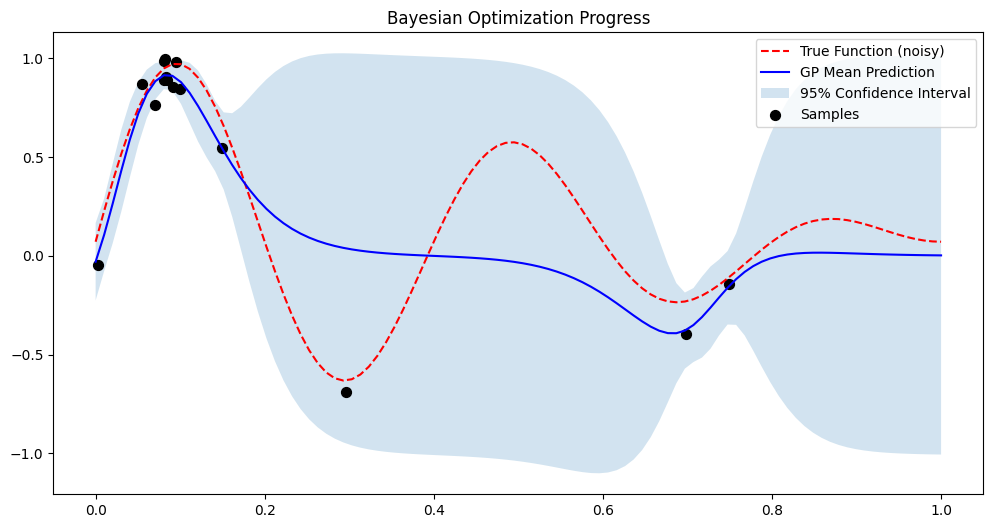

In [32]:
# Plot results
plt.figure(figsize=(12, 6))
X = np.linspace(0, 1, 100).reshape(-1, 1)
Y_pred, sigma = gpr.predict(X, return_std=True)
plt.plot(X, black_box_function(X), 'r--', label="True Function (noisy)")
plt.plot(X, Y_pred, 'b-', label="GP Mean Prediction")
plt.fill_between(X.ravel(),
                 Y_pred.ravel() - 1.96 * sigma,
                 Y_pred.ravel() + 1.96 * sigma,
                 alpha=0.2, label="95% Confidence Interval")
plt.scatter(X_sample, Y_sample, c='black', s=50, label="Samples")
plt.legend()
plt.title("Bayesian Optimization Progress")
plt.show()